In [1]:
!pip install geopandas shapely pyproj matplotlib


In [2]:
!pip install -q leafmap


In [3]:
from google.colab import drive
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np
import folium
from shapely.geometry import Point
import leafmap.foliumap as leafmap
import pandas as pd

In [4]:
drive.mount('/content/drive')
root_dir = '/content/drive/MyDrive/EarthObs'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load shapefile and generate 60×60 grid**

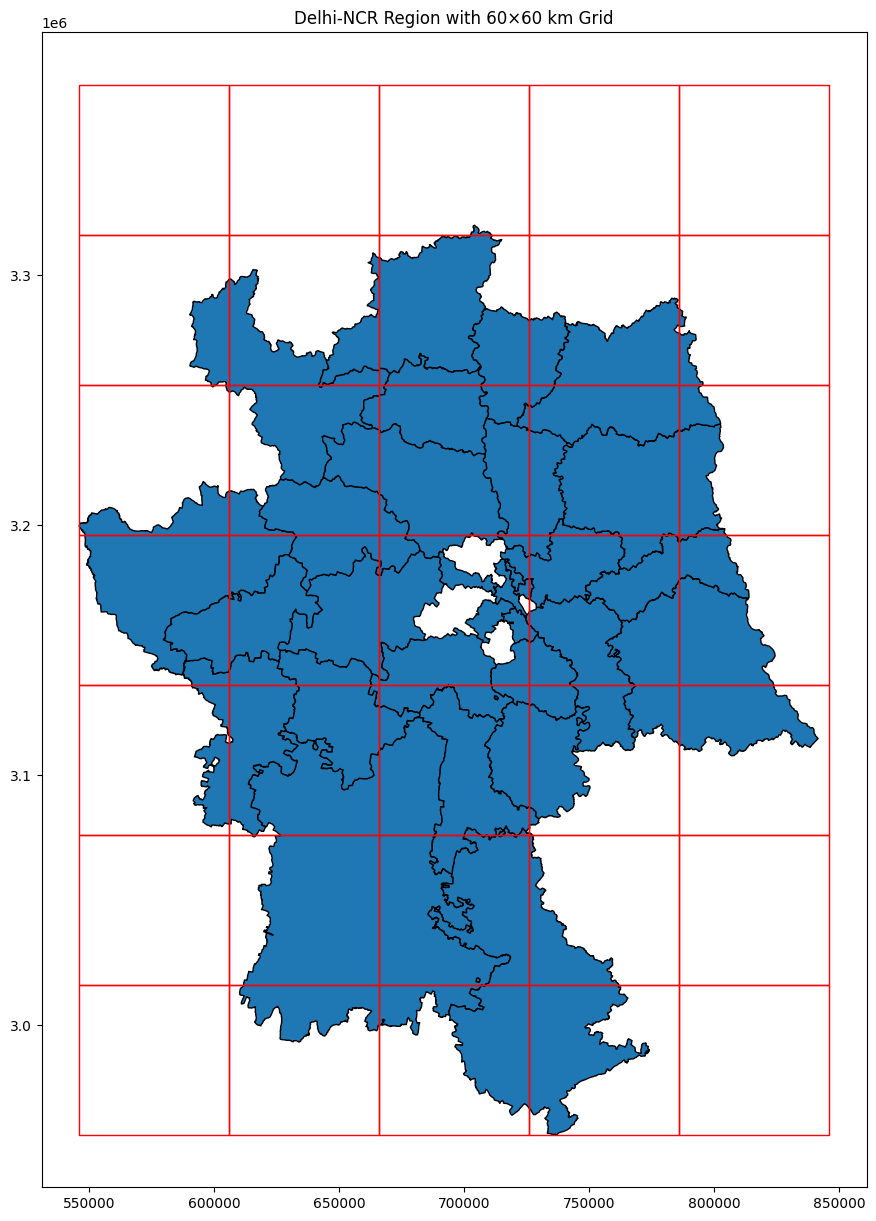

In [5]:
# Load Delhi-NCR shapefile
ncr_path = '/content/drive/MyDrive/EarthObs/delhi_ncr_region.geojson'
delhi_ncr = gpd.read_file(ncr_path)

# Reproject to EPSG:32643 (UTM Zone 43N)
delhi_ncr = delhi_ncr.to_crs(epsg=32643)

# Function to generate uniform grid
def create_grid(gdf, cell_size):
    minx, miny, maxx, maxy = gdf.total_bounds
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    grid_cells = [box(x, y, x + cell_size, y + cell_size) for x in x_coords for y in y_coords]
    return gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)

# Generate 60x60 km grid
grid_60km = create_grid(delhi_ncr, 60000)

# Plot NCR + Grid
ax = delhi_ncr.plot(edgecolor='black', figsize=(15, 15))
grid_60km.boundary.plot(ax=ax, color='red', linewidth=1)
plt.title("Delhi-NCR Region with 60×60 km Grid")
plt.show()


In [6]:
# Reproject both to WGS84 for web mapping
delhi_ncr_wgs84 = delhi_ncr.to_crs(epsg=4326)
grid_wgs84 = grid_60km.to_crs(epsg=4326)

In [7]:
center = delhi_ncr_wgs84.geometry.union_all().centroid

m = leafmap.Map(center=(center.y, center.x), zoom=8)
m.add_basemap("SATELLITE")

m.add_gdf(delhi_ncr_wgs84, layer_name="Delhi-NCR", style={'fillColor': 'transparent', 'color': 'black'})
m.add_gdf(grid_wgs84, layer_name="60x60 Grid", style={'fillColor': 'transparent', 'color': 'red'})
m

**Mark the four corners and the center of each grid cell**

In [8]:
# Add corners + center markers
for _, row in grid_wgs84.iterrows():
    bounds = row.geometry.bounds  # (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = bounds

    # Define corners
    corners = [
        (miny, minx),  # Bottom-left
        (miny, maxx),  # Bottom-right
        (maxy, minx),  # Top-left
        (maxy, maxx)   # Top-right
    ]

    # Center point
    center = ((miny + maxy) / 2, (minx + maxx) / 2)

    # Add corner markers
    for lat, lon in corners:
        folium.CircleMarker(location=[lat, lon], radius=2, color='blue', fill=True).add_to(m)

    # Add center marker
    folium.CircleMarker(location=center, radius=2, color='green', fill=True).add_to(m)

m

In [9]:
rgb_path = '/content/drive/MyDrive/EarthObs/rgb'
image_files = os.listdir(rgb_path)

In [10]:
# Extract lat/lon from filenames like 28.2266_77.5234.png
def extract_latlon(filename):
    parts = filename.replace('.png', '').split('_')
    if len(parts) == 2:
        try:
            lat = float(parts[0])
            lon = float(parts[1])
            return lat, lon, filename
        except:
            return None
    return None

# Apply and clean
coords_data = [extract_latlon(f) for f in image_files]
coords_data = [x for x in coords_data if x is not None]

# Convert to GeoDataFrame
df_coords = pd.DataFrame(coords_data, columns=['lat', 'lon', 'filename'])
gdf_coords = gpd.GeoDataFrame(df_coords, geometry=gpd.points_from_xy(df_coords['lon'], df_coords['lat']))
gdf_coords.set_crs(epsg=4326, inplace=True)
gdf_coords_proj = gdf_coords.to_crs(epsg=32643)

# Spatial filter
filtered = gpd.sjoin(gdf_coords_proj, grid_60km, predicate='within', how='inner')

# Report
print("Images before filtering:", len(image_files))
print("Images after filtering: ", len(filtered))


Images before filtering: 9230
Images after filtering:  9216


In [11]:
!pip install -q rasterio rioxarray xarray geopandas matplotlib seaborn


In [12]:
import rioxarray as rxr
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Load WorldCover GeoTIFF
esa_path = '/content/drive/MyDrive/EarthObs/worldcover_bbox_delhi_ncr_2021.tif'
esa_raster = rxr.open_rasterio(esa_path, masked=True).squeeze()
print("Raster CRS:", esa_raster.rio.crs)
print("Raster shape:", esa_raster.shape)
print("Raster bounds:", esa_raster.rio.bounds())

Raster CRS: EPSG:4326
Raster shape: (9600, 9602)
Raster bounds: (76.84991666666667, 28.199999999999996, 77.65008333333333, 29.0)


In [14]:
filtered_wgs84 = filtered.to_crs(epsg=4326)

In [15]:
patch_size = 128  # Updated to 128 pixels
resolution_deg = 0.0115  # approx 1.28 km at ~28°N

labels = []
valid_filenames = []

for _, row in filtered_wgs84.iterrows():
    lon, lat = row.geometry.x, row.geometry.y

    try:
        window = esa_raster.rio.clip_box(
            minx=lon - resolution_deg / 2, miny=lat - resolution_deg / 2,
            maxx=lon + resolution_deg / 2, maxy=lat + resolution_deg / 2
        )

        patch = window.values
        flat = patch.flatten()
        flat = flat[flat != esa_raster.rio.nodata]

        if len(flat) == 0:
            continue

        class_counts = Counter(flat)
        top_class, count = class_counts.most_common(1)[0]

        if count / len(flat) >= 0.6:
            labels.append(top_class)
            valid_filenames.append(row['filename'])

    except Exception:
        continue

print("Total patches processed:", len(filtered_wgs84))
print("Valid patches (with dominant class):", len(valid_filenames))


Total patches processed: 9216
Valid patches (with dominant class): 6563


In [16]:
esa_label_map = {
    10: 'Tree Cover',
    20: 'Shrubland',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bare/Sparse vegetation',
    70: 'Snow and Ice',
    80: 'Permanent Water Bodies',
    90: 'Herbaceous Wetland',
    95: 'Mangroves',
    100: 'Moss and Lichen'
}


In [17]:
label_names = [esa_label_map.get(code, "Unknown") for code in labels]


In [18]:
df_labeled = pd.DataFrame({
    'filename': valid_filenames,
    'esa_code': labels,
    'label_name': label_names
})
df_labeled.to_csv("labeled_images.csv", index=False)
df_labeled.head()


filename  esa_code label_name
0  28.9090_77.1821.png      40.0   Cropland
1  28.9178_77.3910.png      40.0   Cropland
2  28.9090_77.4321.png      40.0   Cropland
3  28.9090_77.1943.png      40.0   Cropland
4  28.9266_76.9944.png      40.0   Cropland

**how many were skipped due to dominance threshold:**

Patches skipped due to low class dominance: 2653


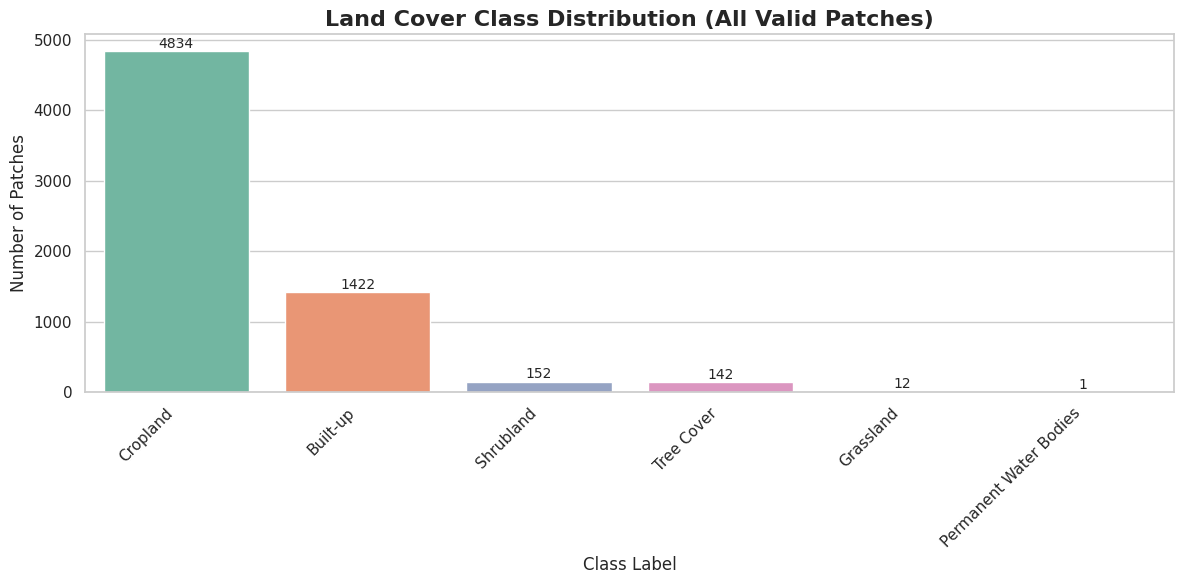

In [19]:
skipped_due_to_mix = len(filtered) - len(valid_filenames)
print(f"Patches skipped due to low class dominance: {skipped_due_to_mix}")

# Count label frequencies
label_counts = df_labeled['label_name'].value_counts().sort_values(ascending=False)

# Set plot style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    palette="Set2"
)

# Add value labels on top of each bar
for i, count in enumerate(label_counts.values):
    barplot.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Customize plot
plt.title("Land Cover Class Distribution (All Valid Patches)", fontsize=16, weight='bold')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Number of Patches", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Count label occurrences
label_counts = df_labeled['label_name'].value_counts()

# Keep only classes with ≥2 samples
valid_labels = label_counts[label_counts >= 2].index
df_labeled_filtered = df_labeled[df_labeled['label_name'].isin(valid_labels)]

# Now do the split
train_df, test_df = train_test_split(
    df_labeled_filtered,
    test_size=0.4,
    random_state=42,
    stratify=df_labeled_filtered['label_name']
)

print(f"Total usable samples: {len(df_labeled_filtered)}")
print(f"Training samples: {len(train_df)}")
print(f"Test samples:     {len(test_df)}")


Total usable samples: 6562
Training samples: 3937
Test samples:     2625


In [22]:
# Extract patch values and remove no-data
patch = window.values
flat = patch.flatten()

# Remove ESA no-data value (e.g., 255 or -9999 depending on source)
flat = flat[~np.isin(flat, [esa_raster.rio.nodata, 255])]

**Model Training**

In [23]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch
from tqdm import tqdm
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Assuming your df_labeled or merged_df has column `label_name`
unique_labels = sorted(df_labeled['label_name'].unique())  # ensures reproducibility

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

print("Labels mapped to indices:")
print(label_to_index)

Labels mapped to indices:
{'Built-up': 0, 'Cropland': 1, 'Grassland': 2, 'Permanent Water Bodies': 3, 'Shrubland': 4, 'Tree Cover': 5}


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet18
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(label_to_index))  # Output classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


Using device: cuda


In [26]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to tensor (C, H, W)
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean for ImageNet
                         [0.229, 0.224, 0.225])  # Std for ImageNet
])

In [27]:
from torch.utils.data import Dataset
from PIL import Image
import os

class PatchDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.loc[idx, 'filename']
        label = self.df.loc[idx, 'label_encoded']
        img_path = os.path.join(self.image_dir, filename)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [28]:
# Encode labels into numerical values
train_df['label_encoded'] = train_df['label_name'].map(label_to_index)
test_df['label_encoded'] = test_df['label_name'].map(label_to_index)

In [29]:
from torch.utils.data import DataLoader

train_dataset = PatchDataset(train_df, image_dir='/content/drive/MyDrive/EarthObs/rgb', transform=transform)
test_dataset = PatchDataset(test_df, image_dir='/content/drive/MyDrive/EarthObs/rgb', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [30]:
from tqdm import tqdm

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Train Accuracy: {acc:.4f}")


Epoch [1/5]: 100%|██████████| 124/124 [00:21<00:00,  5.69it/s]


Epoch [1/5] - Loss: 23.7259 - Train Accuracy: 0.9456


Epoch [2/5]: 100%|██████████| 124/124 [00:22<00:00,  5.45it/s]


Epoch [2/5] - Loss: 14.6771 - Train Accuracy: 0.9792


Epoch [3/5]: 100%|██████████| 124/124 [00:21<00:00,  5.76it/s]


Epoch [3/5] - Loss: 5.8686 - Train Accuracy: 0.9876


Epoch [4/5]: 100%|██████████| 124/124 [00:21<00:00,  5.73it/s]


Epoch [4/5] - Loss: 7.5701 - Train Accuracy: 0.9883


Epoch [5/5]: 100%|██████████| 124/124 [00:21<00:00,  5.78it/s]

Epoch [5/5] - Loss: 15.0314 - Train Accuracy: 0.9759


In [36]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [37]:
from torchmetrics.classification import MulticlassF1Score

# Convert to tensors
preds_tensor = torch.tensor(all_preds)
labels_tensor = torch.tensor(all_labels)

# Instantiate torchmetrics F1 score
f1_metric = MulticlassF1Score(num_classes=len(label_to_index), average='macro')
f1_score_torchmetrics = f1_metric(preds_tensor, labels_tensor)

print(f"Macro F1 Score (torchmetrics): {f1_score_torchmetrics:.4f}")


Macro F1 Score (torchmetrics): 0.7265


Classification Report:
              precision    recall  f1-score   support

    Built-up       0.94      1.00      0.97       569
    Cropland       1.00      0.98      0.99      1933
   Grassland       0.00      0.00      0.00         5
   Shrubland       0.74      0.92      0.82        61
  Tree Cover       0.94      0.79      0.86        57

    accuracy                           0.98      2625
   macro avg       0.72      0.74      0.73      2625
weighted avg       0.98      0.98      0.98      2625



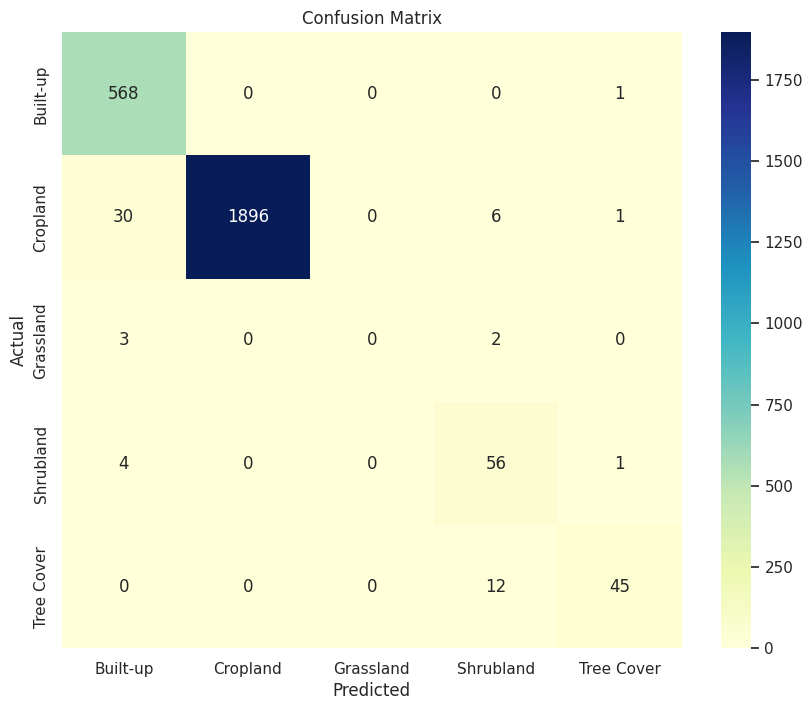

In [33]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get only the classes present in y_true or y_pred
present_labels = sorted(list(set(all_labels + all_preds)))
present_label_names = [index_to_label[i] for i in present_labels]

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds,
                            labels=present_labels,
                            target_names=present_label_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=present_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=present_label_names,
            yticklabels=present_label_names,
            cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()